In [225]:
from typing import Type, Tuple
import matplotlib.pyplot as plt
import numpy as np
import nnfs
from nnfs.datasets import spiral_data, vertical_data

In [3]:
nnfs.init()

In [152]:
# Activation functions
class ActivationFunction:
    def __init__(self) -> None:
        self.inputs: np.ndarray
        self.output: np.ndarray

    def forward(self, inputs: np.ndarray) -> None:
        self.inputs = inputs
        self.output = inputs
        
    def backward(self, dvalues: np.ndarray) -> None:
        self.dinputs = dvalues

class Activation_ReLu(ActivationFunction):
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self, inputs: np.ndarray) -> None:
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        
    def backward(self, dvalues: np.ndarray):
        self.dinputs = np.maximum(0, dvalues)


class Activation_Softmax(ActivationFunction):
    def __init__(self) -> None:
        super().__init__()
        
    def forward(self, inputs: np.ndarray) -> None:
        self.inputs = inputs
        
        exponientiated = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output =  exponientiated / np.sum(exponientiated, axis=1, keepdims=True)
        
class Activation_Linear:

    def forward(self, inputs: np.ndarray) -> None:
        self.inputs = inputs
        self.output = inputs
    
    def backward(self, dvalues: np.ndarray) -> None:
        self.dinputs = dvalues.copy()

In [188]:
# Loss
class Loss:
    def __init__(self) -> None:
        self.inputs: np.ndarray
        self.output: np.ndarray
        
    def forward(self, y_pred: np.ndarray, y: np.ndarray) -> None:
        self.inputs = y_pred
    
    def calculate(self, output: np.ndarray, y: np.ndarray) -> float:
        self.forward(self, output, y)
        return np.mean(self.output)
    
    
class CategoricalCrossEntropy(Loss):
    def __init__(self) -> None:
        super().__init__()
        
    def forward(self, y_pred: np.ndarray, y_true: np.ndarray):
        
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(len(y_pred)), y_true]
        
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
            
        self.output = -np.log(correct_confidences)
        
        
class Activation_Softmax_Loss_CategoricalCrossEntropy:
    def __init__(self) -> None:
        self.activation_function = Activation_Softmax
        self.loss = CategoricalCrossEntropy
        
    def forward(self, inputs: np.ndarray, y_true: np.ndarray) -> float:
        self.activation_function.forward(self.activation_function, inputs)
        
        self.output = self.activation_function.output
        
        return self.loss.calculate(self.loss, self.output, y_true)
    
    def backward(self, dvalues: np.ndarray, y_true: np.ndarray) -> None:
        samples = len(dvalues)
        
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
            
        self.dinputs = dvalues.copy()
        
        self.dinputs[range(samples), y_true] -= 1
        
        self.dinputs = self.dinputs / samples
        
        
class Loss_MSE:
   
        
    def forward(self, ypred: np.ndarray, ytrue: np.ndarray):
        sample_losses = np.mean((ytrue - ypred)**2, axis=-1)
        self.output = sample_losses
        return sample_losses
        
    def backward(self, dvalues: np.ndarray, ytrue: np.ndarray):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        
        
        self.dinputs = -2 * (ytrue - dvalues) / outputs
        self.dinputs = self.dinputs / samples
    
    def calculate(self, output: np.ndarray, y: np.ndarray) -> float:
        self.forward(output, y)
        return np.mean(self.output) 
    
        

In [189]:
mse = Loss_MSE()
ypred = np.array([[0, 0, 0.19]]).T
ytrue = np.array([[-1, 0, 1]]).T
loss = mse.forward(ypred, ytrue)
mse.backward(ypred, ytrue)

mse.calculate(ypred, ytrue)

0.5520333333333334

In [6]:
class Layer_Dense:
    def __init__(self, size: Tuple[int, int]):
        self.size = size
        
        self.weights = np.random.rand(*size)
        self.biases = np.zeros((1, size[1]))
        
        self.inputs: np.ndarray
        self.output: np.ndarray
        
    def forward(self, inputs: np.ndarray):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        
        
    def backward(self, dvalues) -> None:
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)
        
        

In [7]:
class Optimiser:
    def __init__(self, learning_rate, decay) -> None:
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate *  (1 / (1 + self.iterations * self.decay))
    
    def post_update_params(self):
        self.iterations += 1
    
class Optimiser_SGD(Optimiser):
    def __init__(self, learning_rate=1, decay=0, momentum=0) -> None:
        super().__init__(learning_rate, decay)
        self.momentum = momentum
    
         
    def update_params(self, layer: Layer_Dense )-> None:
        
        
        
        if self.momentum:
            if not hasattr(layer, "weights_momentums"):
                layer.weights_momentums = np.zeros_like(layer.weights)
                layer.biases_momentums = np.zeros_like(layer.biases)
                
            
            weight_changes = (layer.weights_momentums * self.momentum) - (self.current_learning_rate * layer.dweights)
            bias_changes = (layer.biases_momentums * self.momentum) - (self.current_learning_rate * layer.dbiases)
                

        else:
            weight_changes = -self.current_learning_rate * layer.dweights
            bias_changes = -self.current_learning_rate * layer.dbiases
        
        layer.weights += weight_changes
        layer.biases += bias_changes
        
        
class Optimiser_Adam(Optimiser):
    def __init__(self, learning_rate=0.001, decay=0, epsilon=1e-7, beta_1=0.9, beta_2=0.999) -> None:
        super().__init__(learning_rate, decay)
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    def update_params(self, layer: Layer_Dense) -> None:
        if not hasattr(layer, "weight_cache"):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_2 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_2 ** (self.iterations + 1))
        
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
        
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
        
        

In [8]:
class NeuralNetwork:
    def __init__(self):
        self.layers: list[Layer_Dense] = []
        self.activation_loss = Activation_Softmax_Loss_CategoricalCrossEntropy()
        self.activation_functions: list[Type[ActivationFunction]] = []
        
    def add(self, size: Tuple[int, int], activation_function: Type[ActivationFunction] = None) -> None:
        self.layers.append(Layer_Dense(size=size))
        if activation_function:
            self.activation_functions.append(activation_function)
            
            
        self.activation_loss_output = 0
    
    
    def set_optimiser(self, optimiser: Type[Optimiser]):
        self.optimiser = optimiser
    
    def propagate_forwards(self, X: np.ndarray, y: np.ndarray) -> None:
        layer_input = X
        
        for layer, activation_function in zip(self.layers[:-1], self.activation_functions):
            layer.forward(layer_input)
            
            
            activation_function.forward(layer.output)
                
            layer_input = activation_function.output
        
        self.layers[-1].forward(layer_input)
        self.loss = self.activation_loss.forward(inputs=self.layers[-1].output, y_true=y)
        self.predictions = np.argmax(self.activation_loss.activation_function.output, axis=1)
    
    def propagate_backwards(self, y) -> None:
        self.activation_loss.backward(self.activation_loss.output, y)
        
        self.layers[-1].backward(self.activation_loss.dinputs)
        layer_dinput = self.layers[-1].dinputs
        for layer, activation_function in zip(self.layers[::-1][1:], self.activation_functions[::-1]):
            

            activation_function.backward(layer_dinput)
            
            layer.backward(activation_function.dinputs)
            layer_dinput = layer.dinputs
            
            
    def optimise(self) -> None:
        for layer in self.layers:
            self.optimiser.pre_update_params()
            self.optimiser.update_params(layer=layer)
            self.optimiser.post_update_params()
    
    def accuracy(self, y_true: np.ndarray) -> float:
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        return np.mean(self.predictions == y_true)
       
    def fit(self, epochs: int, X: np.ndarray, y: np.ndarray) -> None:
        for epoch in range(epochs + 1):
            self.propagate_forwards(X, y)
            self.propagate_backwards(y)
            self.optimise()
            
            if epoch % 1000 == 0:
                print(f"{epoch}. Acc: {round(self.accuracy(y), 2)} | Loss: {round(self.loss, 2)}")    
        

In [ ]:
X, y = spiral_data(100, 3)

network = NeuralNetwork()
network.add(size=(2, 64), activation_function=Activation_ReLu())
network.add(size=(64, 3))
network.set_optimiser(Optimiser_Adam(learning_rate=0.001, decay=1e-6))

network.fit(10000, X, y)

216372.50102734778


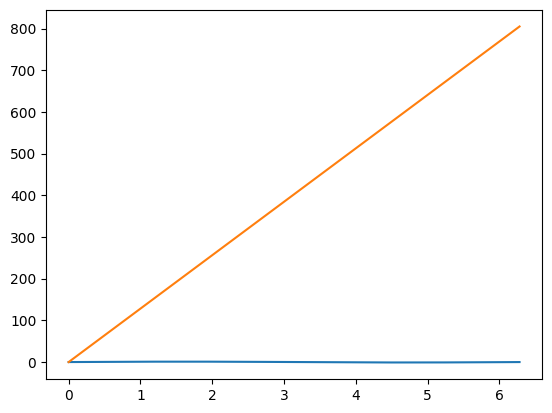

0.49945828941819953


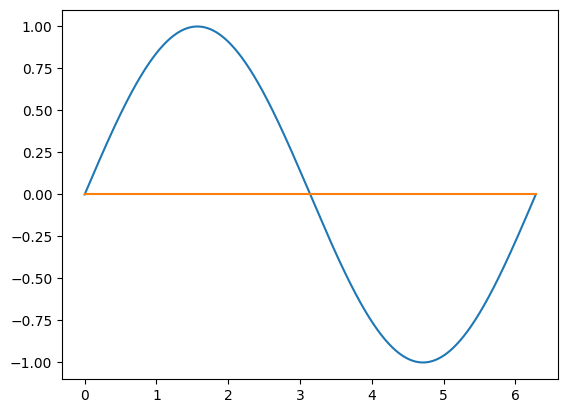

0.49945828941819953


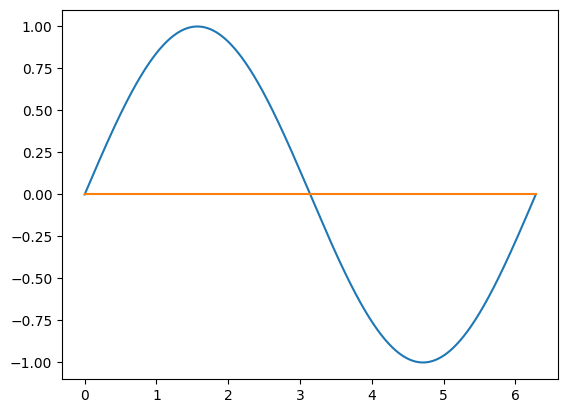

0.49945828941819953


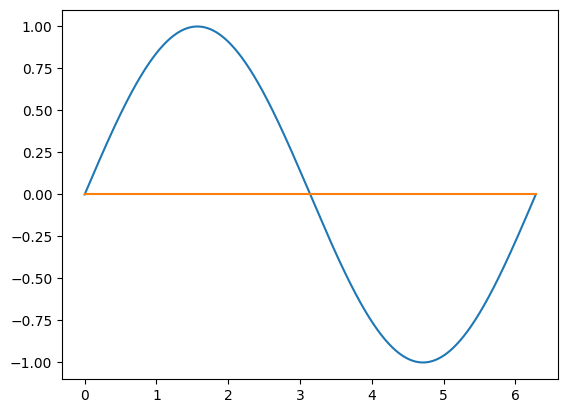

0.49945828941819953


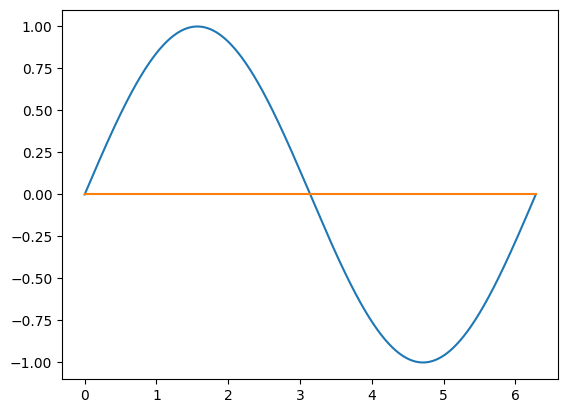

0.49945828941819953


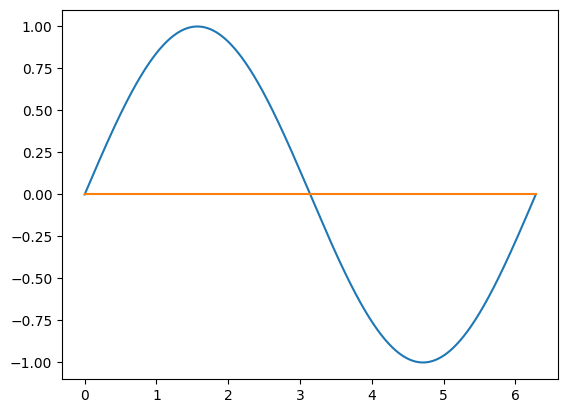

0.49945828941819953


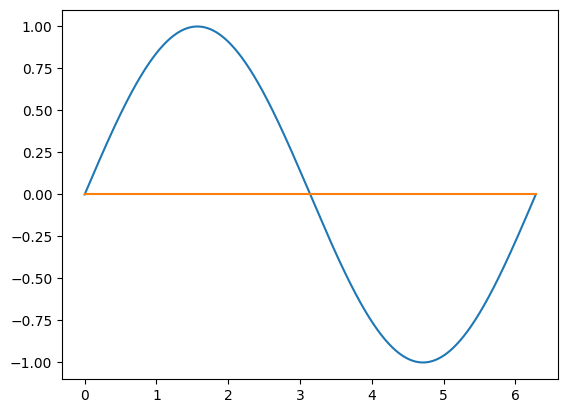

0.49945828941819953


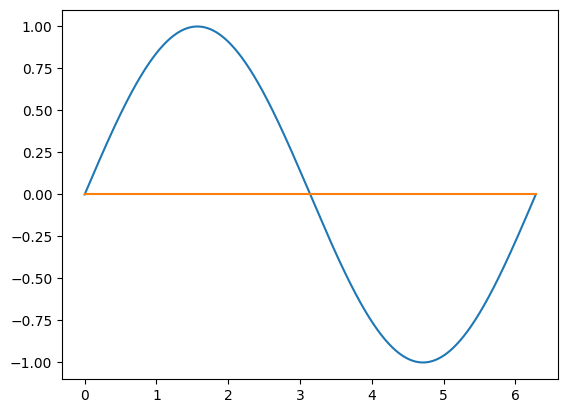

0.49945828941819953


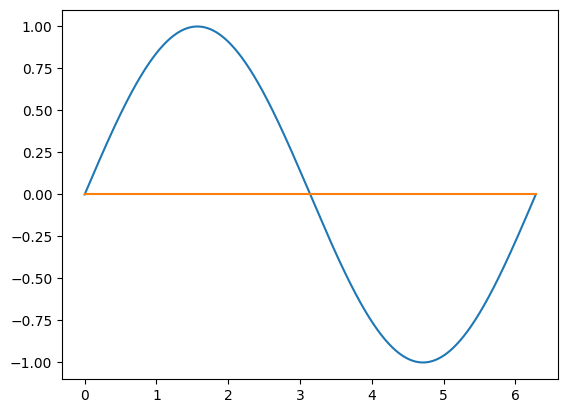

0.49945828941819953


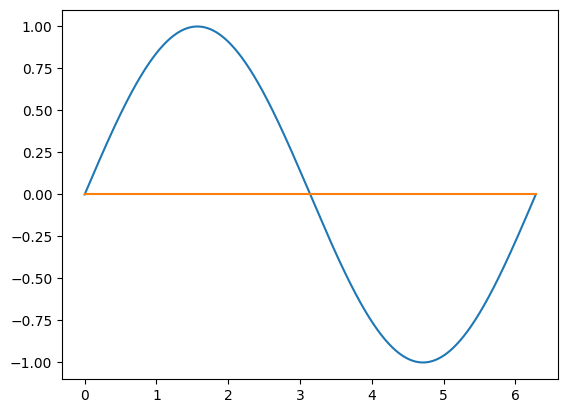

In [232]:
X = np.arange(0, 2 * np.pi, 0.01).reshape(-1, 1)
y = np.sin(X)

dense1 = Layer_Dense((1, 32))
activation1 = Activation_ReLu()
dense2 = Layer_Dense((32, 32))
activation2 = Activation_ReLu()

dense3 = Layer_Dense((32, 1))
activation3 = Activation_Linear()

loss = Loss_MSE()
optmiser = Optimiser_Adam(learning_rate=1)

for epoch in range(10000):
    
    dense1.forward(X)
    activation1.forward(dense1.output)
    
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    
    #loss.forward(activation3.output, y)
    
    
    loss.backward(activation3.output, y)
    
    activation3.backward(loss.dinputs)
    dense3.backward(activation3.dinputs)
    
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optmiser.pre_update_params()
    optmiser.update_params(dense1)
    optmiser.update_params(dense2)
    optmiser.update_params(dense3)
    optmiser.post_update_params()
    
    
    if epoch % 1000 == 0:
        print(loss.calculate(activation3.output, y))
        plt.plot(X, y)
        plt.plot(X, activation3.output)
        plt.show()
    